<a href="https://colab.research.google.com/github/ishaan-arya/automated-essay-grading/blob/working/Automated_Essay_Grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
import seaborn as sns

Data Normalisation

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training_set_rel3.csv to training_set_rel3.csv


In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['training_set_rel3.csv']))

In [ ]:
df2

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,17,18,NaN,35,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12972,21628,8,I never understood the meaning laughter is th...,15,17,NaN,32,NaN,NaN,NaN,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20,26,40.0,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12974,21630,8,Trippin' on fen...,20,20,NaN,40,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,12976.000000,12976.000000,12976.000000,12976.000000,128.000000,12976.000000,1800.000000,1800.000000,1800.000000,2292.000000,2292.000000,2292.000000,2292.000000,723.000000,723.000000,2292.000000,2292.000000,2292.000000,2292.000000,723.000000,723.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,10295.395808,4.179485,4.127158,4.137408,37.828125,6.800247,3.333889,3.330556,3.333889,2.444154,2.557592,2.606457,2.705061,3.731674,3.564315,2.472513,2.577225,2.635689,2.710297,3.777317,3.589212,3.945312,3.890625,4.078125,3.992188,3.843750,3.617188
std,6309.074105,2.136913,4.212544,4.264330,5.240829,8.970705,0.729103,0.726807,0.729103,1.211730,1.061076,1.098196,1.035937,0.717746,0.699980,1.246780,1.085464,1.142566,1.045795,0.689401,0.693256,0.643668,0.630390,0.622535,0.509687,0.538845,0.603417
min,1.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
25%,4438.750000,2.000000,2.000000,2.000000,36.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
50%,10044.500000,4.000000,3.000000,3.000000,40.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,15681.250000,6.000000,4.000000,4.000000,40.000000,8.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,21633.000000,8.000000,30.000000,30.000000,50.000000,60.000000,4.000000,4.000000,4.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000


In [ ]:
df2.shape

(12976, 28)

In [ ]:
df2.dropna(axis=1,inplace=True)
df2.drop(columns=['rater1_domain1','rater2_domain1'],inplace=True,axis=1)
df2

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


In [ ]:
df2.skew()

essay_id         0.044368
essay_set        0.067896
domain1_score    2.475881
dtype: float64

In [ ]:
df2.kurtosis()

essay_id        -1.174375
essay_set       -1.151431
domain1_score    6.077899
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


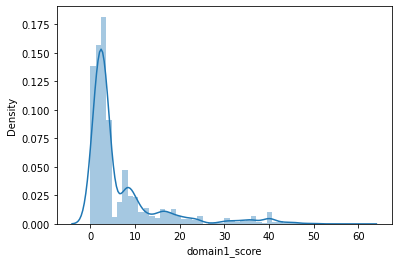

In [ ]:
sns.distplot(df2['domain1_score'])


In [ ]:
min_range = [2,1,0,0,0,0,0,0]
max_range = [12,6,3,3,4,4,30,60]

def normalize(x,mi,ma):
    x = (x-mi)/(ma-mi)
    return round(x*10)

df2['final_score']=df2.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


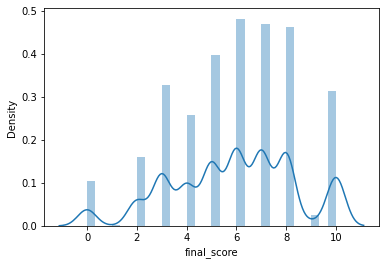

In [ ]:
sns.distplot(df2['final_score'])


In [ ]:
df2.drop('domain1_score',axis=1,inplace=True)

df2.head()

,essay_id,essay_set,essay,final_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [ ]:
df2.describe()

,essay_id,essay_set,final_score
count,12976.000000,12976.000000,12976.000000
mean,10295.395808,4.179485,5.849877
std,6309.074105,2.136913,2.466040
min,1.000000,1.000000,0.000000
25%,4438.750000,2.000000,4.000000
50%,10044.500000,4.000000,6.000000
75%,15681.250000,6.000000,8.000000
max,21633.000000,8.000000,10.000000


In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_essay(essay):
    x=[]
    for i in essay.split():
        if i.startswith("@"):
            continue
        else:
            x.append(i)
    return ' '.join(x)

df2['essay'] = df2['essay'].apply(lambda x:clean_essay(x))

stop_words = set(stopwords.words('english')) 
def remove_stop_words(essay):
    word_tokens = word_tokenize(essay) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

df2['clean_essay'] = df2['essay'].apply(lambda x:remove_stop_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
bigtext = files.upload()

Saving big.txt to big.txt


In [ ]:
def sent2word(x):
    x=re.sub("[^A-Za-z0-9]"," ",x)
    words=nltk.word_tokenize(x)
    return words

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words
        

def noOfWords(essay):
    count=0
    for i in essay2word(essay):
        count=count+len(i)
    return count

def noOfChar(essay):
    count=0
    for i in essay2word(essay):
        for j in i:
            count=count+len(j)
    return count

def avg_word_len(essay):
    return noOfChar(essay)/noOfWords(essay)

def noOfSent(essay):
    return len(essay2word(essay))

def count_pos(essay):
    sentences = essay2word(essay)
    noun_count=0
    adj_count=0
    verb_count=0
    adverb_count=0
    for i in sentences:
        pos_sentence = nltk.pos_tag(i)
        for j in pos_sentence:
            pos_tag = j[1]
            if(pos_tag[0]=='N'):
                noun_count+=1
            elif(pos_tag[0]=='V'):
                verb_count+=1
            elif(pos_tag[0]=='J'):
                adj_count+=1
            elif(pos_tag[0]=='R'):
                adverb_count+=1
    return noun_count,verb_count,adj_count,adverb_count
    
data = open('big.txt').read()
words = re.findall('[a-z]+', data.lower())

def check_spell_error(essay):
    essay=essay.lower()
    new_essay = re.sub("[^A-Za-z0-9]"," ",essay)
    new_essay = re.sub("[0-9]","",new_essay)
    count=0
    all_words = new_essay.split()
    for i in all_words:
        if i not in words:
            count+=1
    return count

Machine Learning

In [ ]:
vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(df2['clean_essay'])
feature_names = vectorizer.get_feature_names()
data = df2[['essay_set','clean_essay','final_score']].copy()
X = count_vectors.toarray()
y = data['final_score'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
from sklearn.metrics import mean_squared_error

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 680292489568085475328.00


In [ ]:
nltk.download('averaged_perceptron_tagger')

pro_data = df2.copy()
pro_data['char_count'] = pro_data['essay'].apply(noOfChar)
pro_data['word_count'] = pro_data['essay'].apply(noOfWords)
pro_data['sent_count'] = pro_data['essay'].apply(noOfSent)
pro_data['avg_word_len'] = pro_data['essay'].apply(avg_word_len)
pro_data['spell_err_count'] = pro_data['essay'].apply(check_spell_error)
pro_data['noun_count'], pro_data['adj_count'], pro_data['verb_count'], pro_data['adv_count'] = zip(*pro_data['essay'].map(count_pos))
pro_data


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,essay_id,essay_set,essay,final_score,clean_essay,char_count,word_count,sent_count,avg_word_len,spell_err_count,noun_count,adj_count,verb_count,adv_count
0,1,1,"Dear local newspaper, I think effects computer...",6,"Dear local newspaper , I think effects compute...",1441,344,16,4.188953,25,76,75,18,24
1,2,1,Dear I believe that using computers will benef...,7,Dear I believe using computers benefit us many...,1765,413,17,4.273608,39,98,84,20,19
2,3,1,"Dear, More and more people use computers, but ...",5,"Dear , More people use computers , everyone ag...",1185,276,14,4.293478,26,76,51,20,16
3,4,1,"Dear Local Newspaper, I have found that many e...",8,"Dear Local Newspaper , I found many experts sa...",2284,490,26,4.661224,75,142,96,39,29
4,5,1,Dear I know having computers has a positive ef...,6,Dear I know computers positive effect people ....,2023,469,30,4.313433,43,110,90,32,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eith...,6,In stories mothers daughters either enemies fr...,3133,810,26,3.867901,45,127,170,51,70
12972,21628,8,I never understood the meaning laughter is the...,5,I never understood meaning laughter shortest d...,1970,526,31,3.745247,29,106,98,41,56
12973,21629,8,"When you laugh, is out of habit, or is cause? ...",7,"When laugh , habit , cause ? What causes laugh...",3256,781,40,4.169014,57,148,170,44,59
12974,21630,8,"Trippin' on fences I am years young, and in th...",7,"Trippin ' fences I years young , short years ,...",2185,556,36,3.929856,53,93,109,42,52


In [ ]:
vectorizer = CountVectorizer(max_features = 5000, ngram_range=(1, 3), stop_words='english')
count_vectors = vectorizer.fit_transform(pro_data['clean_essay'])
feature_names = vectorizer.get_feature_names()
X = count_vectors.toarray()
X_full = np.concatenate((pro_data.iloc[:, 5:].to_numpy(), X), axis = 1)
y_full = pro_data['final_score'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R^2 score: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 6.93
R^2 score: -0.15


In [ ]:
count = 0
total = 0
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

16.0030824556897

In [ ]:
count = 0
total = 0
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

35.03724633958387

In [ ]:
rf = RandomForestRegressor(n_estimators = 300, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R^2 score: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2.06
R^2 score: 0.66


In [ ]:
count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

32.49422039558181

In [ ]:
count = 0
total = 0
rf = RandomForestRegressor(n_estimators = 150, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test).round()
for i in y_test:
  if (y_test[i]==y_pred[i]) or (y_test[i]==y_pred[i]+1) or (y_test[i]==y_pred[i]-1):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

65.96455175956845

In [ ]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R^2 score: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2.06
R^2 score: 0.66


1 4.11302337528898
1 0.31545069576377405
11 2.2606189985226948
11 0.6237548340037875
21 2.1639458468168122
21 0.639844589081811
31 2.1340843574402406
31 0.644814573424473
41 2.1226296229767945
41 0.6467210373055863
51 2.1002126533462944
51 0.650451996155915
61 2.087532256183556
61 0.6525624526895062
71 2.0856083240554435
71 0.6528826615187605
81 2.082643266840732
81 0.6533761495610473
91 2.077575072723938
91 0.6542196723032787
101 2.0721885200444214
101 0.6551161809181212
111 2.0699775880890345
111 0.6554841564421279
121 2.0709830358099857
121 0.6553168151763431
131 2.0671820265834433
131 0.6559494345378225
141 2.0694399777184396
141 0.6555736333965629
151 2.065972437071815
151 0.6561507520561161
161 2.068116333418347
161 0.6557939335752898
171 2.067378538276982
171 0.6559167281973007
181 2.0633657213976093
181 0.6565845996758111
191 2.064203383540557
191 0.65644518373167
201 2.0630641691359135
201 0.6566347883988256
211 2.0620450294451933
211 0.6568044084818024
221 2.0611663131813276


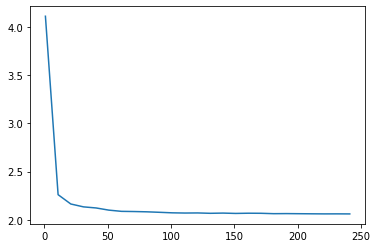

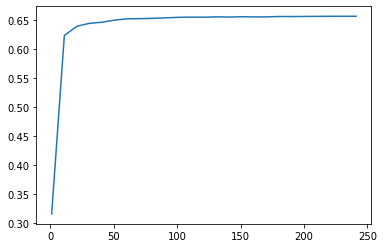

In [ ]:
import matplotlib.pyplot as plt

MSE = []
R2 = []
arr = []
i=1
count = 0
while i<250:
  rf = RandomForestRegressor(n_estimators = i, random_state = 42)
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  MSE.append(mean_squared_error(y_test, y_pred))
  R2.append(r2_score(y_test, y_pred))
  arr.append(i)
  print(i,MSE[count])
  print(i,R2[count])
  count = count+1
  i=i+10
plt.plot(arr,MSE) 
plt.show()
plt.plot(arr,R2) 
plt.show()

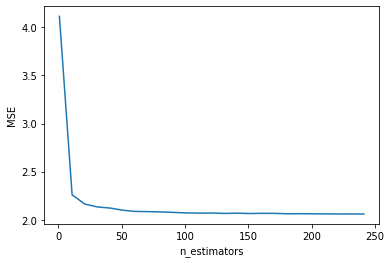

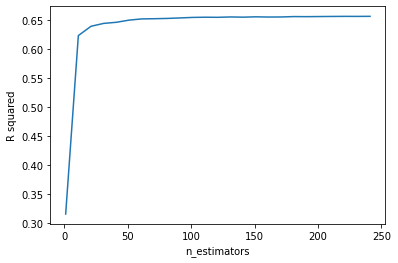

In [ ]:
plt.plot(arr,MSE)
plt.xlabel('n_estimators') 
plt.ylabel('MSE') 
plt.show()

plt.plot(arr,R2) 
plt.xlabel('n_estimators') 
plt.ylabel('R squared') 
plt.show()

In [ ]:
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Mean squared error:%.2f"%mean_squared_error(y_test,y_pred))
for i in y_test:
  if (y_test[i]==y_pred[i]):
    count = count + 1
  total = total + 1
accuracy = count/total*100
accuracy

Mean squared error:3.25


17.518623169791933